# Import libraries

In [5]:
import xarray as xr
import matplotlib.pyplot as plt 
import matplotlib as mpl
import numpy as np
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import sys
import matplotlib.gridspec as gridspec

outdir = '/qfs/people/qiny108/ppe_scripts/decomp_ERFaci_Casey/middata/'
datadir = '/compyfs/qiny108/PPE_postdata/' 

# Functions

## area_averager

In [6]:
def area_averager(data_plot_xr):
    '''
    calculate weighted area mean
    input data is xarray DataArray
    '''
    weights = np.cos(np.deg2rad(data_plot_xr.lat))
    weights.name = "weights"
    # available in xarray version 0.15 and later
    data_weighted = data_plot_xr.weighted(weights)

    weighted_mean = data_weighted.mean(("lat", "lon"))

    return weighted_mean

## save_big_dataset

In [7]:
def save_big_dataset(dic_mod,outfile):
    '''
    create a big dataset based on all variables in a dictionary and save to netcdf file.
    '''
    datalist = []
    for svar in dic_mod.keys():
        data = xr.DataArray(dic_mod[svar],name=svar)
        datalist.append(data)

    data_big = xr.merge(datalist,compat='override')

    #data_big.to_netcdf(outfile,encoding={'time':{'dtype': 'i4'},'bin':{'dtype':'i4'}})
    data_big.to_netcdf(outfile)

## nanarray

In [8]:
def nanarray(vector):
    # this generates a masked array with the size given by vector
    # example: vector = (90,144,28)
    # similar to this=NaN*ones(x,y,z) in matlab
    this=np.ma.zeros(vector)
    this=np.ma.masked_where(this==0,this)

    return this


## map_SWkern_to_lon

In [9]:

def map_SWkern_to_lon(Ksw,albcsmap):
    from scipy.interpolate import interp1d
    ## Map each location's clear-sky surface albedo to the correct albedo bin
    # Ksw is size 12,7,7,lats,3
    # albcsmap is size A,lats,lons
    albcs=np.arange(0.0,1.5,0.5)
    A=albcsmap.shape[0]
    TT=Ksw.shape[1]
    PP=Ksw.shape[2]
    lenlat=Ksw.shape[3]
    lenlon=albcsmap.shape[2]
    SWkernel_map=nanarray((A,TT,PP,lenlat,lenlon))
    for M in range(A):
        MM=M
        while MM>11:
            MM=MM-12
        for LA in range(lenlat):
            alon=albcsmap[M,LA,:]
            # interp1d can't handle mask but it can deal with NaN (?)
            alon2=alon
            if np.count_nonzero(~np.isnan(alon2))>1: # at least 1 unmasked value
                if len(np.where(Ksw[MM,:,:,LA,:]>0))==0:
                    SWkernel_map[M,:,:,LA,:] = 0
                else:
                    f = interp1d(albcs,Ksw[MM,:,:,LA,:],axis=2)
                    ynew = f(alon2.data)
                    SWkernel_map[M,:,:,LA,:] = ynew
            else:
                continue

    return SWkernel_map

## KT_decomposition_general

In [10]:
def KT_decomposition_general(c1, c2, Ksw):
    """
    this function takes in a (month,TAU,CTP,lat,lon) matrix and performs the
    decomposition of Zelinka et al 2013 doi:10.1175/JCLI-D-12-00555.1
    """

    sum_c = c1.sum(dim=['cosp_lwp_modis','cosp_reffliq'])  # Eq. B2
    dc = c2 - c1
    sum_dc = dc.sum(dim=['cosp_lwp_modis','cosp_reffliq'])
    dc_prop = c1 * (sum_dc / sum_c)
    dc_star = dc - dc_prop  # Eq. B1
    C_ratio = c1 / sum_c

    # SW components
    Ksw0 = (Ksw * c1 / sum_c).sum(dim=['cosp_lwp_modis','cosp_reffliq'])  # Eq. B4
    Ksw_prime = Ksw - Ksw0  # Eq. B3
    Ksw_lwp_prime = (Ksw_prime * (C_ratio.sum(dim="cosp_lwp_modis"))).sum(dim="cosp_reffliq")  # Eq. B7
    Ksw_nd_prime = (Ksw_prime * (C_ratio.sum(dim="cosp_reffliq"))).sum(dim="cosp_lwp_modis")  # Eq. B8
    Ksw_resid_prime = Ksw_prime - Ksw_lwp_prime - Ksw_nd_prime  # Eq. B9
    dRsw_true = (Ksw * dc).sum(dim=["cosp_reffliq", "cosp_lwp_modis"])  # SW total
    dRsw_prop = Ksw0 * sum_dc  # SW amount component
    dRsw_dctp = (Ksw_lwp_prime * (dc_star.sum(dim="cosp_reffliq"))).sum(
        dim="cosp_lwp_modis"
    )  # SW lwp component
    dRsw_dtau = (Ksw_nd_prime * (dc_star.sum(dim="cosp_lwp_modis"))).sum(
        dim="cosp_reffliq"
    )  # SW nd component
    dRsw_resid = (Ksw_resid_prime * dc_star).sum(dim=["cosp_reffliq", "cosp_lwp_modis"])  # SW residual
    # dRsw_sum = dRsw_prop + dRsw_dctp + dRsw_dtau + dRsw_resid

    # Set SW fields to zero where the sun is down
    dRsw_true = xr.where(Ksw0 == 0, 0, dRsw_true)
    dRsw_prop = xr.where(Ksw0 == 0, 0, dRsw_prop)
    dRsw_dctp = xr.where(Ksw0 == 0, 0, dRsw_dctp)
    dRsw_dtau = xr.where(Ksw0 == 0, 0, dRsw_dtau)
    dRsw_resid = xr.where(Ksw0 == 0, 0, dRsw_resid)

    output = {}
    output["SWcld_tot"] = dRsw_true.transpose("time", "lat", "lon")
    output["SWcld_amt"] = dRsw_prop.transpose("time", "lat", "lon")
    output["SWcld_lwp"] = dRsw_dctp.transpose("time", "lat", "lon")
    output["SWcld_reff"] = dRsw_dtau.transpose("time", "lat", "lon")
    output["SWcld_err"] = dRsw_resid.transpose("time", "lat", "lon")

    return output


# Read data

In [11]:
ff2 = '/qfs/people/qiny108/ppe_scripts/decomp_ERFaci_Casey/SW_kernel.nc'

with xr.open_dataset(ff2) as f1:
    SWkernel=f1['SW_kernel']
print(SWkernel.shape) 
# print(SWkernel.coords)

nyears = 10

lats=SWkernel.lat.values
# lons=np.arange(1.25,360,2.5)
lons = np.arange(0,360,1) 
print(lons.shape) 

exps = ['PD','PI']
cases = [
    '20230505.v2.F1850.MODISHist.CNTL_PDaer.ne30pg2_EC.compy',
    '20230504.v2.F1850.MODISHist.CNTL.ne30pg2_EC.compy',
    ] 

dic = {} 
for exp,case in zip(exps, cases):  
    dic[exp] = {} 
    for svar in ['CLMODIS_LWPR','FSDSC','FSNSC',]:   
        ff = datadir+case+'/'+svar+'_'+exp+'_000101-001012.nc'

        with xr.open_dataset(ff) as f1:
            if svar == 'CLMODIS_LWPR': 
                da = f1[svar].interp(lat=lats,lon=lons).transpose('time','cosp_lwp_modis','cosp_reffliq','lat','lon')
            else:
                da = f1[svar].interp(lat=lats,lon=lons)
        
        print(svar, da.shape)
        dic[exp][svar] = da

print(dic.keys()) 



(12, 7, 6, 180, 3)
(360,)
CLMODIS_LWPR (120, 7, 6, 180, 360)
FSDSC (120, 180, 360)
FSNSC (120, 180, 360)
CLMODIS_LWPR (120, 7, 6, 180, 360)
FSDSC (120, 180, 360)
FSNSC (120, 180, 360)
dict_keys(['PD', 'PI'])


# Calc albedo and mapping SWkernel

In [12]:
albcs1=xr.DataArray((dic['PD']['FSDSC']-dic['PD']['FSNSC'])/dic['PD']['FSDSC'], coords=dic['PD']['FSDSC'].coords) 
albcs1=xr.where(albcs1>1.,1,albcs1)
albcs1=xr.where(albcs1<0.,0,albcs1)
print(albcs1.shape)

# testing albedo map 
# fig = plt.figure(figsize=(12,6))
# ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree(180))

# im = ax.contourf(albcs1.lon, albcs1.lat, albcs1.mean(axis=0),transform=ccrs.PlateCarree())
# ax.coastlines()
# fig.colorbar(im)
# sys.exit() 

avgalbcs1 = albcs1.groupby('time.month').mean('time') 

SWkernel_map_tmp = map_SWkern_to_lon(SWkernel,avgalbcs1)
SWkernel_map = xr.DataArray(np.tile(SWkernel_map_tmp,(nyears,1,1,1,1)), coords=dic['PD']['CLMODIS_LWPR'].coords) 

print(SWkernel_map.shape)

(120, 180, 360)
(120, 7, 6, 180, 360)


# Calc kernel * CLD anomalies

In [13]:
cld_ano = xr.DataArray(dic['PD']['CLMODIS_LWPR'] - dic['PI']['CLMODIS_LWPR'], coords = dic['PD']['CLMODIS_LWPR'].coords) 

output_SW = xr.DataArray(cld_ano * SWkernel_map, coords = dic['PD']['CLMODIS_LWPR'].coords) 
print(output_SW.shape)

output_SW_avg = output_SW.sum(axis=1).sum(axis=1).mean(axis=0)
print(output_SW_avg.shape) 

(120, 7, 6, 180, 360)
(180, 360)


# Decomposition

In [14]:
dcld_dT = cld_ano
c1 = dic['PI']['CLMODIS_LWPR']
c2 = c1 + dcld_dT
Ksw = SWkernel_map

output = KT_decomposition_general(c1, c2, Ksw)

/qfs/people/qiny108/miniconda3/envs/cdat82/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/qfs/people/qiny108/miniconda3/envs/cdat82/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/qfs/people/qiny108/miniconda3/envs/cdat82/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [15]:
print(output.keys())

output_avg = {} 
for key in output.keys():
    output_avg[key] = output[key].mean(axis=0) 
    tmp = area_averager(output[key].mean(axis=0)).values 
    print(key, tmp)

dict_keys(['SWcld_tot', 'SWcld_amt', 'SWcld_lwp', 'SWcld_reff', 'SWcld_err'])
SWcld_tot -1.347860146447377
SWcld_amt -0.1060114660886235
SWcld_lwp -0.5325191225199603
SWcld_reff -0.6194469161656658
SWcld_err -0.08988098259626842


# Plotting

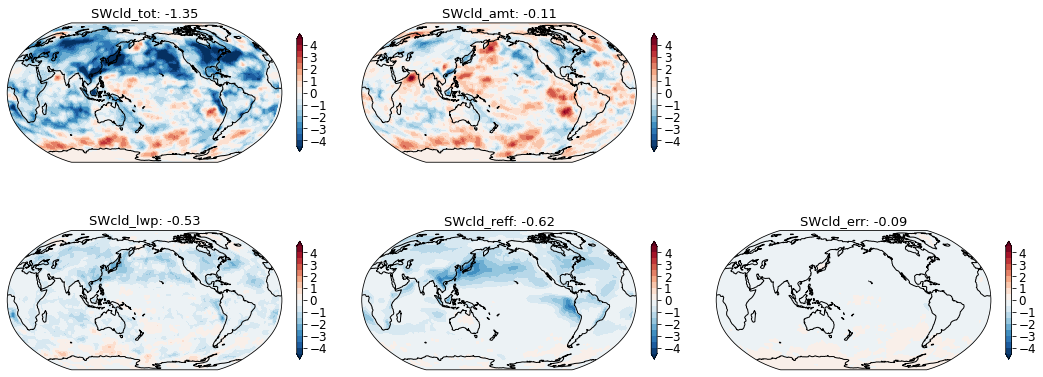

In [16]:
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 13


fig = plt.figure(figsize=(18,7))
nrow = 2
ncol = 3

gs = gridspec.GridSpec(nrow,ncol) 
gs_ids = [
    [0,0],[0,1],
    [1,0],[1,1],[1,2]
          ]

levels = np.arange(-4.5,5,0.5)  

ii = 0 
for key in output.keys():
    data = output[key].mean(axis=0)  
    title = key 
    ax = fig.add_subplot(gs[gs_ids[ii][0],gs_ids[ii][1]],projection=ccrs.Robinson(180))
    im = ax.contourf(lons,lats,data,transform=ccrs.PlateCarree(),cmap='RdBu_r',norm=mcolors.CenteredNorm(), levels=levels,extend='both') 
    ax.coastlines()
    ax.set_global()
    avg = area_averager(data).values 
    ax.set_title(title+': '+str(np.round(avg,2))) 
    fig.colorbar(im,fraction=0.02) 
    ii += 1 


# Save output into NC file

In [17]:

save_big_dataset(output_avg,outdir+'decomp_SW_ERFaci_Casey.nc')

In [18]:
print(SWkernel_map.shape)

(120, 7, 6, 180, 360)


# Save SWkernel map for comparison

In [19]:
dic_out = {} 
dic_out['SWkernel_map'] = SWkernel_map 
save_big_dataset(dic_out, outdir+'SWkernel_map.nc') 